In [1]:
import openeo
import pyrosm
from shapely import geometry

In [2]:
def bbox_to_spatial_extent(bbox) -> dict:
    west, south, east, north = bbox
    return {"west": west, "south": south, "east": east, "north": north}

<Axes: >

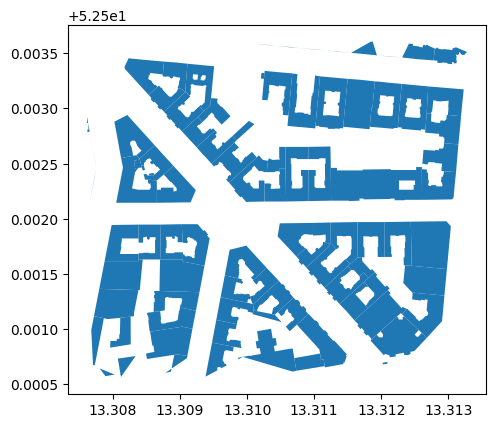

In [3]:
fp = pyrosm.get_data("Berlin")
poly = geometry.Polygon(
    [
        [13.304447427503845, 52.503613765718],
        [13.3058623290448, 52.50185728912493],
        [13.30708783431615, 52.500039702782146],
        [13.31304824632042, 52.50054836324884],
        [13.313449320773088, 52.50326111967763],
        [13.304447427503845, 52.503613765718],
    ]
)
bbox = [13.307595132829988, 52.50054853432778, 13.313285933932065, 52.5036081890986]

# Initialize the OSM parser object
osm = pyrosm.OSM(
    fp,
    bbox,
)

buildings = osm.get_buildings()
buildings.plot()

# building_polygons = [shapely.geometry.box(*bbox) for bbox in osm_data["geometry"]]
# building_gdf = gpd.GeoDataFrame(geometry=building_polygons)

In [4]:
buildings["geometry"]

0     POLYGON ((13.30865 52.50214, 13.30916 52.50215...
1     POLYGON ((13.30771 52.50111, 13.30767 52.50099...
2     POLYGON ((13.30807 52.50073, 13.30811 52.50059...
3     POLYGON ((13.30910 52.50073, 13.30911 52.50075...
4     POLYGON ((13.30811 52.50110, 13.30810 52.50095...
                            ...                        
85    POLYGON ((13.30780 52.50064, 13.30802 52.50058...
86    POLYGON ((13.31312 52.50242, 13.31315 52.50267...
87    POLYGON ((13.31315 52.50267, 13.31318 52.50286...
88    POLYGON ((13.30951 52.50338, 13.30931 52.50340...
89    POLYGON ((13.30818 52.50336, 13.30836 52.50324...
Name: geometry, Length: 90, dtype: geometry

In [5]:
con = openeo.connect("https://openeo.dataspace.copernicus.eu/openeo/1.2")
con.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2' with OidcBearerAuth>

In [8]:
def copernicus_datacube(bbox, time_range, bands):
    datacube = con.load_collection("SENTINEL2_L2A",
                                   spatial_extent=bbox,
                                   temporal_extent=time_range,
                                   bands=bands,
                                   max_cloud_cover=20)
    return datacube

def RGB_composite(datacube):
    march = datacube.filter_temporal("2023-03-01", "2023-04-01")
    april = datacube.filter_temporal("2023-04-01", "2023-05-01")
    may = datacube.filter_temporal("2023-05-01", "2023-06-01")
    mean_march = march.mean_time()
    mean_april = april.mean_time()
    mean_may = may.mean_time()
    R_band = mean_march.rename_labels(dimension="bands", target=["B04"])
    G_band = mean_april.rename_labels(dimension="bands", target=["B03"])
    B_band = mean_may.rename_labels(dimension="bands", target=["B02"])
    NIR_band = mean_may.rename_labels(dimension="bands", target=["B08"])

    RG = R_band.merge_cubes(G_band)
    RGB = RG.merge_cubes(B_band)

    return RGB

def save_RGB_result(RGB_datacube, output_format="GTiff"):
    RGB = RGB_datacube.save_result(format=output_format)

    job = RGB.create_job()
    job.start_and_wait().download_results()

time_range = ["2023-03-01", "2023-06-01"]
bands = ["B04", "B03", "B02", "B08", "SCL"]

datacube = copernicus_datacube(bbox_to_spatial_extent(bbox), time_range, bands)
RGB_datacube = RGB_composite(datacube)
save_RGB_result(RGB_datacube)
#result = RGB_datacube.download("lena.png", "PNG")

0:00:00 Job 'j-24050966933243f28d1620af2eb89fa5': send 'start'
0:00:15 Job 'j-24050966933243f28d1620af2eb89fa5': created (progress 0%)
0:00:21 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:00:31 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:00:48 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:00:59 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:01:12 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:01:27 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:01:47 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:02:11 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:02:41 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:03:19 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:04:06 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:05:04 Job 'j-24050966933243f28d1620af2eb89fa5': queued (progress 0%)
0:06:05 Job '